In [41]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

## Load DataFrames

In [42]:
# Current version of combined_test_sample_submission.csv has lightgbm

full_prediction_df = pd.read_csv('local_test_results.csv')
# LightGBM only:
full_prediction_df = full_prediction_df.rename({'Prediction' : 'prediction',
                           'True_Label' : 'label'}, axis=1)

# TabPFN results
# full_prediction_df = pd.read_csv('combined_validation_tabpfn.csv')

In [43]:
# Slice predictions df to get split per table
covtype_pred = full_prediction_df[full_prediction_df['Domain'] == 'CoverType']
heloc_pred = full_prediction_df[full_prediction_df['Domain'] == 'HELOC']
higgs_pred = full_prediction_df[full_prediction_df['Domain'] == 'Higgs']

In [44]:
tables_pred = [covtype_pred, heloc_pred, higgs_pred]
names = ['CoverType', 'HELOC', 'Higgs']

## Analyse distribution of labels

In [45]:
for table, name in zip(tables_pred, names):
    print(name)
    print('Number of rows:', len(table))
    print('Number of classes:', len(table['prediction'].unique()))
    print()

CoverType
Number of rows: 11616
Number of classes: 7

HELOC
Number of rows: 1912
Number of classes: 2

Higgs
Number of rows: 34975
Number of classes: 2



/tmp/ipykernel_9326/1851429573.py:23: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


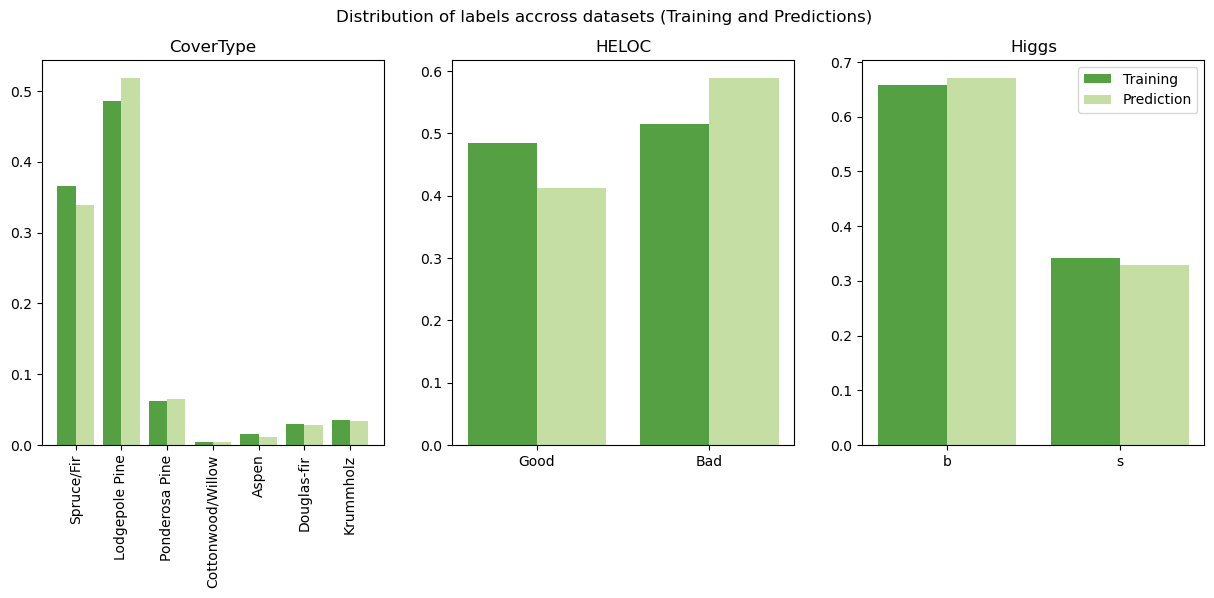

In [46]:
fig, axs = plt.subplots(nrows=1, 
                        ncols=3,
                        figsize=(15,5))

fig.suptitle('Distribution of labels accross datasets (Training and Predictions)')

for i in range(len(tables_pred)):
    labels, train_counts = np.unique(tables_pred[i]['label'], return_counts=True)
    _, pred_counts = np.unique(tables_pred[i]['prediction'], return_counts=True)
    
    axs[i].bar(labels - 0.2, train_counts / sum(train_counts), width=0.4, color='#54a043', label='Training')
    axs[i].bar(labels + 0.2, (pred_counts / sum(pred_counts)), width=0.4, color='#c4dea4', label='Prediction')
    axs[i].set_title(names[i])

    # Set singular legend
    if i == 2:
        axs[2].legend()

axs[0].set_xticks(range(1,8), ['Spruce/Fir', 'Lodgepole Pine', 'Ponderosa Pine', 'Cottonwood/Willow', 'Aspen', 'Douglas-fir', 'Krummholz'], rotation=90)
axs[1].set_xticks([0,1], ['Good', 'Bad'])
axs[2].set_xticks([0,1], ['b', 's'])

fig.show()

## Calculated metrics

In [47]:
for table, name in zip(tables_pred, names):
    print(name)
    correct = table[table['label'] == table['prediction']]
    print('Accuracy:', len(correct) / len(table))
    print()
    print()

correct = full_prediction_df[full_prediction_df['label'] == full_prediction_df['prediction']]
print('Concatenated')
print('Accuracy:', len(correct) / len(full_prediction_df))

CoverType
Accuracy: 0.9087465564738292


HELOC
Accuracy: 0.6997907949790795


Higgs
Accuracy: 0.8349106504646175


Concatenated
Accuracy: 0.847267179349731


In [48]:
# Precision and recall per class for CovType
metrics = {}
names = ['Spruce/Fir', 'Lodgepole Pine', 'Ponderosa Pine', 'Cottonwood/Willow', 'Aspen', 'Douglas-fir', 'Krummholz']

for covtype in range(1,8):
    # print(f'Class {names[covtype - 1]}')
    class_selection = covtype_pred[(covtype_pred['label'] == covtype) | (covtype_pred['prediction'] == covtype)]
    tp = len(class_selection[class_selection['prediction'] == class_selection['label']])
    fp = len(class_selection[(class_selection['prediction'] != class_selection['label']) & (class_selection['prediction'] == covtype)])
    fn = len(class_selection[(class_selection['prediction'] != class_selection['label']) & (class_selection['label'] == covtype)])

    accuracy = tp / len(covtype_pred[covtype_pred['label'] == covtype])
    precision = tp / (tp + fp)
    recall = tp / (tp + fn)

    f1 = (2*precision*recall)/(precision + recall)

    metrics[names[covtype-1]] = [accuracy, precision, recall, f1, len(covtype_pred[covtype_pred['label'] == covtype])]

    # print('Accuracy:', accuracy)
    # print('Precision:', precision)
    # print('Recall:', recall)
    # print('F1 score:', f1)
    # print()

covtype_metrics = pd.DataFrame.from_dict(metrics, orient='index', columns=['accuracy', 'precision', 'recall', 'f1', 'n'])
covtype_metrics

,accuracy,precision,recall,f1,n
Spruce/Fir,0.870536,0.939878,0.870536,0.903879,4256
Lodgepole Pine,0.951681,0.893189,0.951681,0.921508,5650
Ponderosa Pine,0.927878,0.893191,0.927878,0.910204,721
Cottonwood/Willow,0.730769,0.844444,0.730769,0.783505,52
Aspen,0.629032,0.854015,0.629032,0.724458,186
Douglas-fir,0.824047,0.848943,0.824047,0.836310,341
Krummholz,0.900000,0.941327,0.900000,0.920200,410


In [49]:
# Calculate aggregated metrics of covtype using weighted average

agg_metrics = []

for metric in covtype_metrics.columns[:-1]:
    agg_metrics.append(sum(covtype_metrics[metric] * covtype_metrics['n']) / sum(covtype_metrics['n']))

agg_metrics.append(sum(covtype_metrics['n']))
agg_metrics_series = pd.DataFrame(agg_metrics, index=['accuracy', 'precision', 'recall', 'f1', 'n'], columns=['covtype']).transpose()
print(agg_metrics_series)

         accuracy  precision    recall        f1        n
covtype  0.908747   0.909851  0.908747  0.908027  11616.0


In [50]:
# Precision and recall per class for CovType
# for table in [heloc_pred, higgs_pred]:
print(f'Heloc')
tp = len(heloc_pred[(heloc_pred['prediction'] == heloc_pred['label']) & (heloc_pred['prediction'] == 1)])
tn = len(heloc_pred[(heloc_pred['prediction'] != heloc_pred['label']) & (heloc_pred['prediction'] == 0)])
fp = len(heloc_pred[(heloc_pred['prediction'] != heloc_pred['label']) & (heloc_pred['prediction'] == 1)])
fn = len(heloc_pred[(heloc_pred['prediction'] != heloc_pred['label']) & (heloc_pred['prediction'] == 0)])

accuracy = (tp + tn) / len(heloc_pred)
precision = tp / (tp + fp)
recall = tp / (tp + fn)
f1 = (2 * precision * recall) / (precision + recall)

print('Accuracy:', accuracy)
print('Precision:', precision)
print('Recall:', recall)
print('F1 score:', f1)
print()

metrics['heloc'] = [accuracy, precision, recall, f1, len(heloc_pred)]

print(f'Higgs')
tp = len(higgs_pred[(higgs_pred['prediction'] == higgs_pred['label']) & (higgs_pred['prediction'] == 1)])
tn = len(higgs_pred[(higgs_pred['prediction'] == higgs_pred['label']) & (higgs_pred['prediction'] == 0)])
fp = len(higgs_pred[(higgs_pred['prediction'] != higgs_pred['label']) & (higgs_pred['prediction'] == 1)])
fn = len(higgs_pred[(higgs_pred['prediction'] != higgs_pred['label']) & (higgs_pred['prediction'] == 0)])

accuracy = (tp + tn) / len(higgs_pred)
precision = tp / (tp + fp)
recall = tp / (tp + fn)
f1 = (2 * precision * recall) / (precision + recall)

print('Accuracy', accuracy)
print('Precision:', precision)
print('Recall:', recall)
print('F1 score:', f1)
print()

metrics['higgs'] = [accuracy, precision, recall, f1, len(higgs_pred)]

Heloc
Accuracy: 0.5151673640167364
Precision: 0.6826666666666666
Recall: 0.7796954314720812
F1 score: 0.7279620853080568

Higgs
Accuracy 0.8349106504646175
Precision: 0.7684630738522954
Recall: 0.7403227154920157
F1 score: 0.7541304718105944



In [51]:
metrics_df = pd.DataFrame.from_dict(metrics, orient='index', columns=['accuracy', 'precision', 'recall', 'f1', 'n'])
metrics_df

,accuracy,precision,recall,f1,n
Spruce/Fir,0.870536,0.939878,0.870536,0.903879,4256
Lodgepole Pine,0.951681,0.893189,0.951681,0.921508,5650
Ponderosa Pine,0.927878,0.893191,0.927878,0.910204,721
Cottonwood/Willow,0.730769,0.844444,0.730769,0.783505,52
Aspen,0.629032,0.854015,0.629032,0.724458,186
Douglas-fir,0.824047,0.848943,0.824047,0.836310,341
Krummholz,0.900000,0.941327,0.900000,0.920200,410
heloc,0.515167,0.682667,0.779695,0.727962,1912
higgs,0.834911,0.768463,0.740323,0.754130,34975


In [52]:
# Weigh aggregation per dataset (not over full data)

# Concatenate all three datasets to one dataframe
agg_df = pd.concat([agg_metrics_series,metrics_df.loc['heloc':]])
print(agg_df)
print()
print(agg_df.agg('mean'))

         accuracy  precision    recall        f1        n
covtype  0.908747   0.909851  0.908747  0.908027  11616.0
heloc    0.515167   0.682667  0.779695  0.727962   1912.0
higgs    0.834911   0.768463  0.740323  0.754130  34975.0

accuracy         0.752942
precision        0.786993
recall           0.809588
f1               0.796707
n            16167.666667
dtype: float64


In [53]:
# Weight aggregation per sample (so over full data)
agg_metrics = []
agg_df = pd.concat([agg_metrics_series,metrics_df.loc['heloc':]])

for metric in agg_df.columns[:-1]:
    agg_metrics.append(sum(agg_df[metric] * agg_df['n']) / sum(agg_df['n']))

agg_metrics.append(sum(covtype_metrics['n']))
agg_metrics_series = pd.DataFrame(agg_metrics, index=['accuracy', 'precision', 'recall', 'f1', 'n'], columns=['covtype']).transpose()
print(agg_metrics_series)

         accuracy  precision    recall        f1        n
covtype  0.839989   0.798942  0.782211  0.789956  11616.0
